In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import cv2
import csv
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
tf.keras.backend.set_image_data_format('channels_last')

In [7]:
train_path = os.path.join("data", "train")
valid_path = os.path.join("data", "valid")
test_path = './data/test'

In [8]:
train_path = './data/train/'
valid_path = './data/valid'
test_csv = './data/test.csv'

In [9]:
CLASSES = os.listdir(train_path)
CLASSES[:5]

['agkistrodon-contortrix',
 'agkistrodon-piscivorus',
 'coluber-constrictor',
 'crotalus-atrox',
 'crotalus-horridus']

In [5]:
def append_ext(fn):    # Helper function to append extention name for image id
    return fn + ".jpg"

## Data Preprocess

In [11]:
bs = 64
ep = 10

In [12]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

In [13]:
train_batches = datagen \
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=CLASSES, batch_size=bs)
valid_batches = datagen \
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=CLASSES, batch_size=bs)

Found 12777 images belonging to 35 classes.
Found 3184 images belonging to 35 classes.


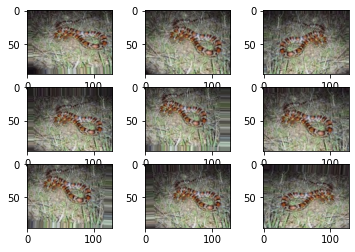

In [14]:
img = load_img('data/train/pantherophis-guttatus/030747b0f4.jpg')        # Sample Image

data = img_to_array(img)

samples = np.expand_dims(data, 0)


it = datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
# show the figure
plt.show()

In [26]:
model = load_modelo("./saved-models/")

AttributeError: 'str' object has no attribute 'decode'

In [30]:
model = Sequential()

In [31]:
for layer in resnet.layers[:-1]:
    model.add(layer)
for layer in model.layers[:-2]:
    layer.trainable = False

ValueError: Input 0 of layer conv2_block1_3_conv is incompatible with the layer: expected axis -1 of input shape to have value 64 but received input with shape [None, 25, 25, 256]